In [1]:
import pandas as pd
from pathlib import Path
import inspect 
import numpy as np
import datetime
import os
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from matplotlib.ticker import MaxNLocator
from dotmap import DotMap
import torch
import torch.nn.init as init
import torch.nn as nn
import pickle
import torch.autograd as autograd
from torchviz import make_dot
from torchsummary import summary
from termcolor import colored
import seaborn as sns
sns.set_theme(style="white", rc={"axes.grid": False})


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import wasserstein_distance, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
reserved = int(torch.cuda.max_memory_reserved() / 1000 / 1000)
gpu_available = torch.cuda.is_available()

print(colored(f"GPU available! {torch.cuda.get_device_name()}. Memory reserved: {reserved}MB", "green") if gpu_available else colored("No GPU. Running on CPU", "red"))

GPU available! NVIDIA GeForce RTX 3060. Memory reserved: 0MB


## Research Notes and Progress

**Current Status**
1. Should we do $X_{t0} \rightarrow NEE_{t1}$ instead of current $X_{t0} \rightarrow NEE_{t0}$ and see if we beat RFR at this
2. MSE experiments
3. Architecture experiments

In [3]:
timestamp = datetime.datetime.now()
timestamp = f"{timestamp.year}-{timestamp.month}-{timestamp.day}_{timestamp.hour}-{timestamp.minute}-{timestamp.second}-{timestamp.microsecond}"

save_dir = Path(timestamp)
if save_dir.exists():
    raise f"Directory exists: {save_dir.as_posix()}"
os.makedirs(save_dir.as_posix())

In [4]:
config = DotMap({"flux_model": "day", "model_type:": "AE"})

In [5]:
writer = SummaryWriter(save_dir.joinpath("tensorboard"))

## Model Building and Training

### Data

In [6]:
data = pd.read_parquet("../data_manipulation/final_day_data.parquet")

In [7]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [8]:
drivers = np.array(['Ta', 'H', 'Tau', 'LE_strg', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2'])

In [9]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [10]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [11]:
data.shape

(28341, 77)

In [12]:
drivers = np.concatenate([drivers, [season_feat], time_feat])

In [13]:
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa", "dRg"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

### Training Data 

In [14]:
train_data, test_data = split_data(data)

In [15]:
drivers = np.append(drivers, ["NEE", "E0", "rb", "alpha", "beta"])

In [16]:
X_train = train_data[drivers]
NEE_train = train_data["NEE_next"]
dT_train = train_data["dTa"]
dRg_train = train_data["dRg"]
dNEE_train = train_data["dNEE"]
bNEE_train = train_data["NEE"]
K_train = train_data[["E0", "rb", "alpha", "beta"]]

X_test = test_data[drivers]
NEE_test = test_data["NEE_next"]
dT_test = test_data["dTa"]
dRg_test = test_data["dRg"]
dNEE_test = test_data["dNEE"]
bNEE_test = test_data["NEE"]
K_test = test_data[["E0", "rb", "alpha", "beta"]]


In [17]:
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [18]:
with open(save_dir.joinpath("normalizer.pickle"), "wb") as fp:
    pickle.dump(normalizer, fp)

In [19]:
config.data.X = drivers.tolist()
config.data.train_size = X_train.shape[0]
config.data.train_start_date = train_data["DateTime"].iloc[0].ctime()
config.data.train_end_date = train_data["DateTime"].iloc[-1].ctime()
config.data.test_size = X_test.shape[0]
config.data.test_start_date = test_data["DateTime"].iloc[0].ctime()
config.data.test_end_date = test_data["DateTime"].iloc[-1].ctime()


### Model Building

In [20]:
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        # Apply He initialization
        init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias)

In [21]:
class AE(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_dims, decoder_dims, activation=nn.Tanh):
        super(AE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.Tref = torch.tensor(10).to("cuda")
        self.T0 = torch.tensor(46.02).to("cuda")
        self.encoder_dims = encoder_dims
        self.decoder_dims = decoder_dims
        
        # Encoder network
        modules = self.append_linear_modules(self.input_dim, self.encoder_dims)
        print(modules)
        self.encoder = nn.Sequential(*modules)
        
       # Decoder network for NEE (u)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.nee_decoder = nn.Sequential(*modules)

        # Decoder network for E0 and rb and alpha and beta
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 4))
        self.k_decoder = nn.Sequential(*modules)
        

    def append_linear_modules(self, in_dim, dims):
        modules = []
        for i, dim in enumerate(dims):
            modules.append(nn.Linear(in_dim, dim))
            if i != len(dims) - 1:
                modules.append(self.activation())
            in_dim = dim
        return modules
   
    def forward(self, x):
        z = self.encoder(x)
        k = self.k_decoder(z)
        
        nee = self.nee_decoder(z)
        
        return nee, k, z


In [22]:
def loss_function(nee_pred, nee_true, latent, z_prior, k_pred, k_true, loss_fn):
    # MMD Loss for NEE (u)
    mmd_loss_nee = loss_fn(nee_pred, nee_true) + loss_fn(latent, z_prior)

    # MMD Loss for E0 and rb (k)
    # MMD Loss for E0 and rb (k)
    E0_pred, rb_pred, alpha_pred, beta_pred = k_pred[:, 0], k_pred[:, 1], k_pred[:, 2], k_pred[:, 3]
    E0_true, rb_true, alpha_true, beta_true = k_true[:, 0], k_true[:, 1], k_true[:, 2], k_true[:, 3]
    
    mmd_loss_E0 = loss_fn(E0_pred.view((-1, 1)), E0_true.view((-1, 1)))
    mmd_loss_rb = loss_fn(rb_pred.view((-1, 1)), rb_true.view((-1, 1)))
    mmd_loss_alpha = loss_fn(alpha_pred.view((-1, 1)), alpha_true.view((-1, 1)))
    mmd_loss_beta = loss_fn(beta_pred.view((-1, 1)), beta_true.view((-1, 1)))

    return mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_loss_alpha, mmd_loss_beta


In [23]:
class MMD_loss(nn.Module):
    'description'
    # function class which calculates the MMD distance of 2 distributions

    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [24]:
class ClimateDataset(Dataset):
    def __init__(self, X, k, dNEE, bNEE, dT, dRg, NEE):
        """
        Args:
            X (numpy array): Input data of shape (n_samples, input_dim)
            k (numpy array): Ground truth for E0, rb, alpha and beta shape (n_samples, 4)
            dNEE (numpy array): Ground truth for f, shape (n_samples, 1)
            bNEE (numpy array): Ground truth for NEE at current t (boundary condition), shape (n_samples, 1)
            dT (numpy array): Ground truth for temperature derivative, shape (n_samples, 1)
            dRg (numpy array): Ground truth for radiation derivative, shape (n_samples, 1)
            NEE (numpy array): Ground truth for NEE at t + 1, shape (n_samples, 1)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.k = torch.tensor(k, dtype=torch.float32)
        self.dNEE = torch.tensor(dNEE, dtype=torch.float32)
        self.bNEE = torch.tensor(NEE, dtype=torch.float32)
        self.dT = torch.tensor(dT, dtype=torch.float32)
        self.dRg = torch.tensor(dRg, dtype=torch.float32)
        self.NEE = torch.tensor(NEE, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get current NEE and previous NEE for boundary condition
        NEE_current = self.NEE[idx]
        
        return {
            'X': self.X[idx],
            'k': self.k[idx],
            'dNEE': self.dNEE[idx],
            'bNEE': self.bNEE[idx],
            'dT': self.dT[idx],
            'dRg': self.dRg[idx],
            'NEE': NEE_current
        }


### Training Setup

In [25]:

lr = 1e-3

model = AE(input_dim=X_train.shape[1], latent_dim=32, encoder_dims=[16, 32], decoder_dims = [16, 16], activation=nn.ReLU)
model.apply(initialize_weights)
with open(save_dir.joinpath("model.txt"), "w") as fp:
    fp.write(str(model))

model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
train_dataset = ClimateDataset(X_train, K_train.values, dNEE_train.values, bNEE_train.values, dT_train.values, dRg_train.values, NEE_train.values)
test_dataset = ClimateDataset(X_test, K_test.values, dNEE_test.values, bNEE_test.values, dT_test.values, dRg_test.values, NEE_test.values)

# Create a DataLoader instance
train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

[Linear(in_features=20, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=32, bias=True)]


In [26]:
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (k_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [27]:
loss_fn = MMD_loss()

config.model.activation = str(model.activation)
config.model.lr = lr
config.model.loss_fn = str(loss_fn)

with open(save_dir.joinpath("loss_function.txt"), "w") as fp:
    fp.write(inspect.getsource(loss_function))

In [28]:
for i, batch in enumerate(train_data_loader):
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    f = batch['dNEE'].to("cuda")
    b = batch['bNEE'].to("cuda")
    yhat = model(x)
    if i == 2:
        break
make_dot(yhat, params=dict(list(model.named_parameters()))).render(save_dir.joinpath("pivae"), format="png")

'2024-9-1_21-27-25-615332/pivae.png'

In [29]:
num_epochs = 2000
patience = 50
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)

config.training.patience = patience
config.training.num_epochs = num_epochs

In [30]:
with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

### Training

In [31]:
best_test_loss = float('inf')
best_model_path = save_dir.joinpath('best_model.pth')

In [32]:
epoch = 0

##### Control Room

In [33]:
# CONTROL ROOM
loss_fn = MMD_loss()
# loss_fn = nn.MSELoss()  #nn.L1Loss()
for g in optimizer.param_groups:
    g['lr'] = 0.0001

##### Back to training

In [35]:
loss_name = "MSE" if str(loss_fn) == 'MSELoss()' else "MMD"


while epoch < num_epochs:

    train_loss = []
    test_loss = []
    
    train_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [], "mmd_loss_alpha": [], "mmd_loss_beta": []})
    # Example of iterating over the DataLoader in the training loop
    for batch in train_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, k_pred, z = model(x)
        
        # Extract E0,rb,alpha,beta predictions
        E0_pred, rb_pred, alpha_pred, beta_pred = k_pred[:, 0], k_pred[:, 1], k_pred[:, 2], k_pred[:, 3]

        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb, mmd_loss_alpha, mmd_loss_beta = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, k_pred, k, loss_fn)
        loss = mmd_loss_nee + mmd_loss_E0 + mmd_loss_rb + mmd_loss_alpha + mmd_loss_beta

        train_losses.mmd_loss_nee.append(mmd_loss_nee)
        train_losses.mmd_loss_E0.append(mmd_loss_E0)
        train_losses.mmd_loss_rb.append(mmd_loss_rb)
        train_losses.mmd_loss_alpha.append(mmd_loss_alpha)
        train_losses.mmd_loss_beta.append(mmd_loss_beta)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())
    
    print(colored("Training Loss: {}".format(np.mean(train_loss)), "blue"))
    writer.add_scalar("Train Loss", np.mean(train_loss), epoch)
    
    for col in train_losses.keys():
        l = [x.cpu().detach().numpy() for x in train_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Train Loss [{col}]", np.mean(l), epoch)
    print("\n")

    test_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [], "mmd_loss_alpha": [], "mmd_loss_beta": []})

    for batch in test_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, k_pred, z = model(x)
        
        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb, mmd_loss_alpha, mmd_loss_beta = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, k_pred, k, loss_fn)
        loss = mmd_loss_nee + mmd_loss_E0 + mmd_loss_rb + mmd_loss_alpha + mmd_loss_beta
        
        test_loss.append(loss.cpu().detach().numpy())

        test_losses.mmd_loss_nee.append(mmd_loss_nee)
        test_losses.mmd_loss_E0.append(mmd_loss_E0)
        test_losses.mmd_loss_rb.append(mmd_loss_rb)
        test_losses.mmd_loss_alpha.append(mmd_loss_alpha)
        test_losses.mmd_loss_beta.append(mmd_loss_beta)
       
    print(colored("Test Loss: {}".format(np.mean(test_loss)), "red"))
    writer.add_scalar("Test Loss", np.mean(test_loss), epoch)
    
    for col in test_losses.keys():
        l = [x.cpu().detach().numpy() for x in test_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Test Loss [{col}]", np.mean(l), epoch)
    print("\n\n")

    # Save best model
    if epoch % 5 == 0 and np.mean(test_loss) < best_test_loss:
            best_test_loss = np.mean(test_loss)
            torch.save(model.state_dict(), best_model_path)
            print(colored(f'New best model saved at epoch {epoch+1} with test loss: {best_test_loss:.4f}',  "light_grey"))

    scheduler.step(np.mean(test_loss))
    epoch += 1




Training Loss: 10.87258243560791
mmd_loss_nee 1.6176151 mmd_loss_E0 6.615621 mmd_loss_rb 0.7579919 mmd_loss_alpha 0.445055 mmd_loss_beta 1.4362986 

Test Loss: 11.447619438171387
mmd_loss_nee 2.0956748 mmd_loss_E0 6.423583 mmd_loss_rb 0.9921646 mmd_loss_alpha 0.30395713 mmd_loss_beta 1.6322397 


New best model saved at epoch 36 with test loss: 11.4476
Training Loss: 10.671186447143555
mmd_loss_nee 1.6035296 mmd_loss_E0 6.611342 mmd_loss_rb 0.749183 mmd_loss_alpha 0.28155673 mmd_loss_beta 1.4255754 

Test Loss: 11.523545265197754
mmd_loss_nee 2.0727825 mmd_loss_E0 6.416342 mmd_loss_rb 0.9837695 mmd_loss_alpha 0.42843747 mmd_loss_beta 1.6222142 


Training Loss: 10.55777645111084
mmd_loss_nee 1.5869737 mmd_loss_E0 6.606387 mmd_loss_rb 0.7404917 mmd_loss_alpha 0.212456 mmd_loss_beta 1.4114677 

Test Loss: 11.612920761108398
mmd_loss_nee 2.0571628 mmd_loss_E0 6.4084463 mmd_loss_rb 0.97470385 mmd_loss_alpha 0.56190234 mmd_loss_beta 1.610705 


Training Loss: 10.5217924118042
mmd_loss_nee 1

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x73d36a56b320>>
Traceback (most recent call last):
  File "/home/cognitia/miniconda3/envs/pytorch/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Training Loss: 10.269312858581543
mmd_loss_nee 1.5087754 mmd_loss_E0 6.5617 mmd_loss_rb 0.6888913 mmd_loss_alpha 0.21551016 mmd_loss_beta 1.2944376 

Test Loss: 11.483429908752441
mmd_loss_nee 1.9477397 mmd_loss_E0 6.33757 mmd_loss_rb 0.90487564 mmd_loss_alpha 0.77336854 mmd_loss_beta 1.519876 




KeyboardInterrupt: 

In [27]:
model.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (k_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=4, bias=True)
  )
)

## Evaluation and Analysis

In [28]:
def compute_mmd(Y, Y_hat, kernel='rbf', gamma=1.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - kernel: string, type of kernel ('rbf', 'linear')
    - gamma: float, kernel coefficient for RBF kernel
    
    Returns:
    - float: MMD value
    """
    Y = Y.reshape(-1, 1)  # Reshape if Y is a 1D array
    Y_hat = Y_hat.reshape(-1, 1)  # Reshape if Y_hat is a 1D array

    if kernel == 'rbf':
        K_yy = rbf_kernel(Y, Y, gamma=gamma)
        K_yhatyhat = rbf_kernel(Y_hat, Y_hat, gamma=gamma)
        K_yyhat = rbf_kernel(Y, Y_hat, gamma=gamma)
    elif kernel == 'linear':
        K_yy = np.dot(Y, Y.T)
        K_yhatyhat = np.dot(Y_hat, Y_hat.T)
        K_yyhat = np.dot(Y, Y_hat.T)
    else:
        raise ValueError("Unsupported kernel")

    mmd = np.mean(K_yy) + np.mean(K_yhatyhat) - 2 * np.mean(K_yyhat)
    return np.sqrt(mmd)

from scipy.stats import entropy

def compute_kl_divergence(Y, Y_hat, bins=100):
    """
    Compute the Kullback-Leibler (KL) Divergence between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - bins: int, number of bins for histogram
    
    Returns:
    - float: KL Divergence
    """
    hist_Y, bin_edges = np.histogram(Y, bins=bins, density=True)
    hist_Y_hat, _ = np.histogram(Y_hat, bins=bin_edges, density=True)

    # Adding a small epsilon to avoid log(0)
    epsilon = 1e-10
    hist_Y = hist_Y + epsilon
    hist_Y_hat = hist_Y_hat + epsilon

    # Normalize the histograms
    hist_Y /= np.sum(hist_Y)
    hist_Y_hat /= np.sum(hist_Y_hat)

    return entropy(hist_Y, hist_Y_hat)


In [29]:
model.load_state_dict(torch.load("ae_day/best_model.pth", weights_only=True))

<All keys matched successfully>

In [30]:

for batch in test_data_loader:
    x = batch['X'].to("cuda")
    nee = batch['NEE'].to("cuda")
            
    nee_pred, k, z  = model(x)
    print(z)
    break

tensor([[ 0.3738,  0.6295,  1.0573,  ..., -0.8019,  0.5507,  0.6781],
        [ 0.3127,  0.7657,  0.8723,  ..., -0.5220,  0.3424,  0.9364],
        [ 0.2965,  1.1025,  0.2842,  ...,  0.5485, -0.4229,  1.5133],
        ...,
        [ 0.4118,  1.7153,  0.2850,  ...,  1.6203, -2.1964,  2.4278],
        [ 0.4168,  1.6879,  0.2637,  ...,  1.6705, -2.2326,  2.4168],
        [-0.5628,  0.8390,  2.9323,  ..., -2.7922,  2.0344,  0.7012]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [31]:
preds = DotMap({"nee": [], "E0": [], "rb": [] , "alpha": [], "beta": []})
gt = DotMap({"nee": [], "E0": [], "rb": [] , "alpha": [], "beta": []})


for batch in test_data_loader:
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    nee = batch['NEE'].to("cuda")
            
    nee_pred, k_pred, z = model(x)
    E0_pred, rb_pred, alpha_pred, beta_pred = k_pred[:, 0], k_pred[:, 1], k_pred[:, 2], k_pred[:, 3]
    
    preds.nee.extend(nee_pred.cpu().detach().numpy().tolist())
    preds.E0.extend(E0_pred.cpu().detach().numpy().tolist())
    preds.rb.extend(rb_pred.cpu().detach().numpy().tolist())
    preds.alpha.extend(alpha_pred.cpu().detach().numpy().tolist())
    preds.beta.extend(beta_pred.cpu().detach().numpy().tolist())
    
    
    gt.nee.extend(nee.cpu().detach().numpy().tolist())
    gt.E0.extend(k[:, 0].cpu().detach().numpy().tolist())
    gt.rb.extend(k[:, 1].cpu().detach().numpy().tolist())
    gt.alpha.extend(k[:, 2].cpu().detach().numpy().tolist())
    gt.beta.extend(k[:, 3].cpu().detach().numpy().tolist())
    
for col in preds:
    preds[col] = np.array(preds[col])
    if len(preds[col].shape) > 1 and preds[col].shape[1] == 1:
        preds[col] = preds[col].flatten()
for col in gt:
    gt[col] = np.array(gt[col])
    if len(gt[col].shape) > 1 and gt[col].shape[1] == 1:
        gt[col] = gt[col].flatten()

In [32]:
print(colored("Metrics ", "red"))
for col in gt:
    mmd = compute_mmd(gt[col], preds[col])
    wasstn = wasserstein_distance(gt[col], preds[col])
    kl = compute_kl_divergence(gt[col], preds[col])
    mae = mean_absolute_error(gt[col], preds[col])
    r2 = r2_score(gt[col], preds[col])
    print(colored(col, "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    config.eval.mae[col] = mean_absolute_error(gt[col], preds[col])
    config.eval.r2[col] = r2_score(gt[col], preds[col])

with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

Metrics 
nee 
MMD: 0.027100437211578763, Wasstn: 0.20540631614385157, KL: 0.07147784258208753, MAE: 1.4659066405169388, R2: 0.8756088560330779
E0 
MMD: 0.11875324419921336, Wasstn: 1.145526901740663, KL: 0.4651776791110341, MAE: 2.2364401361699264, R2: 0.9882311586923076
rb 
MMD: 0.03770962154770768, Wasstn: 0.09104822646537686, KL: 0.06788966749469307, MAE: 0.24715974492529488, R2: 0.9773151756200289
alpha 
MMD: 0.019610685869905185, Wasstn: 0.025101845667079015, KL: 0.9594958761160076, MAE: 0.0484886830328558, R2: -1.1172814737827133
beta 
MMD: 0.23951917313941373, Wasstn: 2.212248917918031, KL: 0.34872284917872653, MAE: 3.387776138940945, R2: 0.9974421240249927


/tmp/ipykernel_49593/857010699.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/tmp/ipykernel_49593/857010699.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)


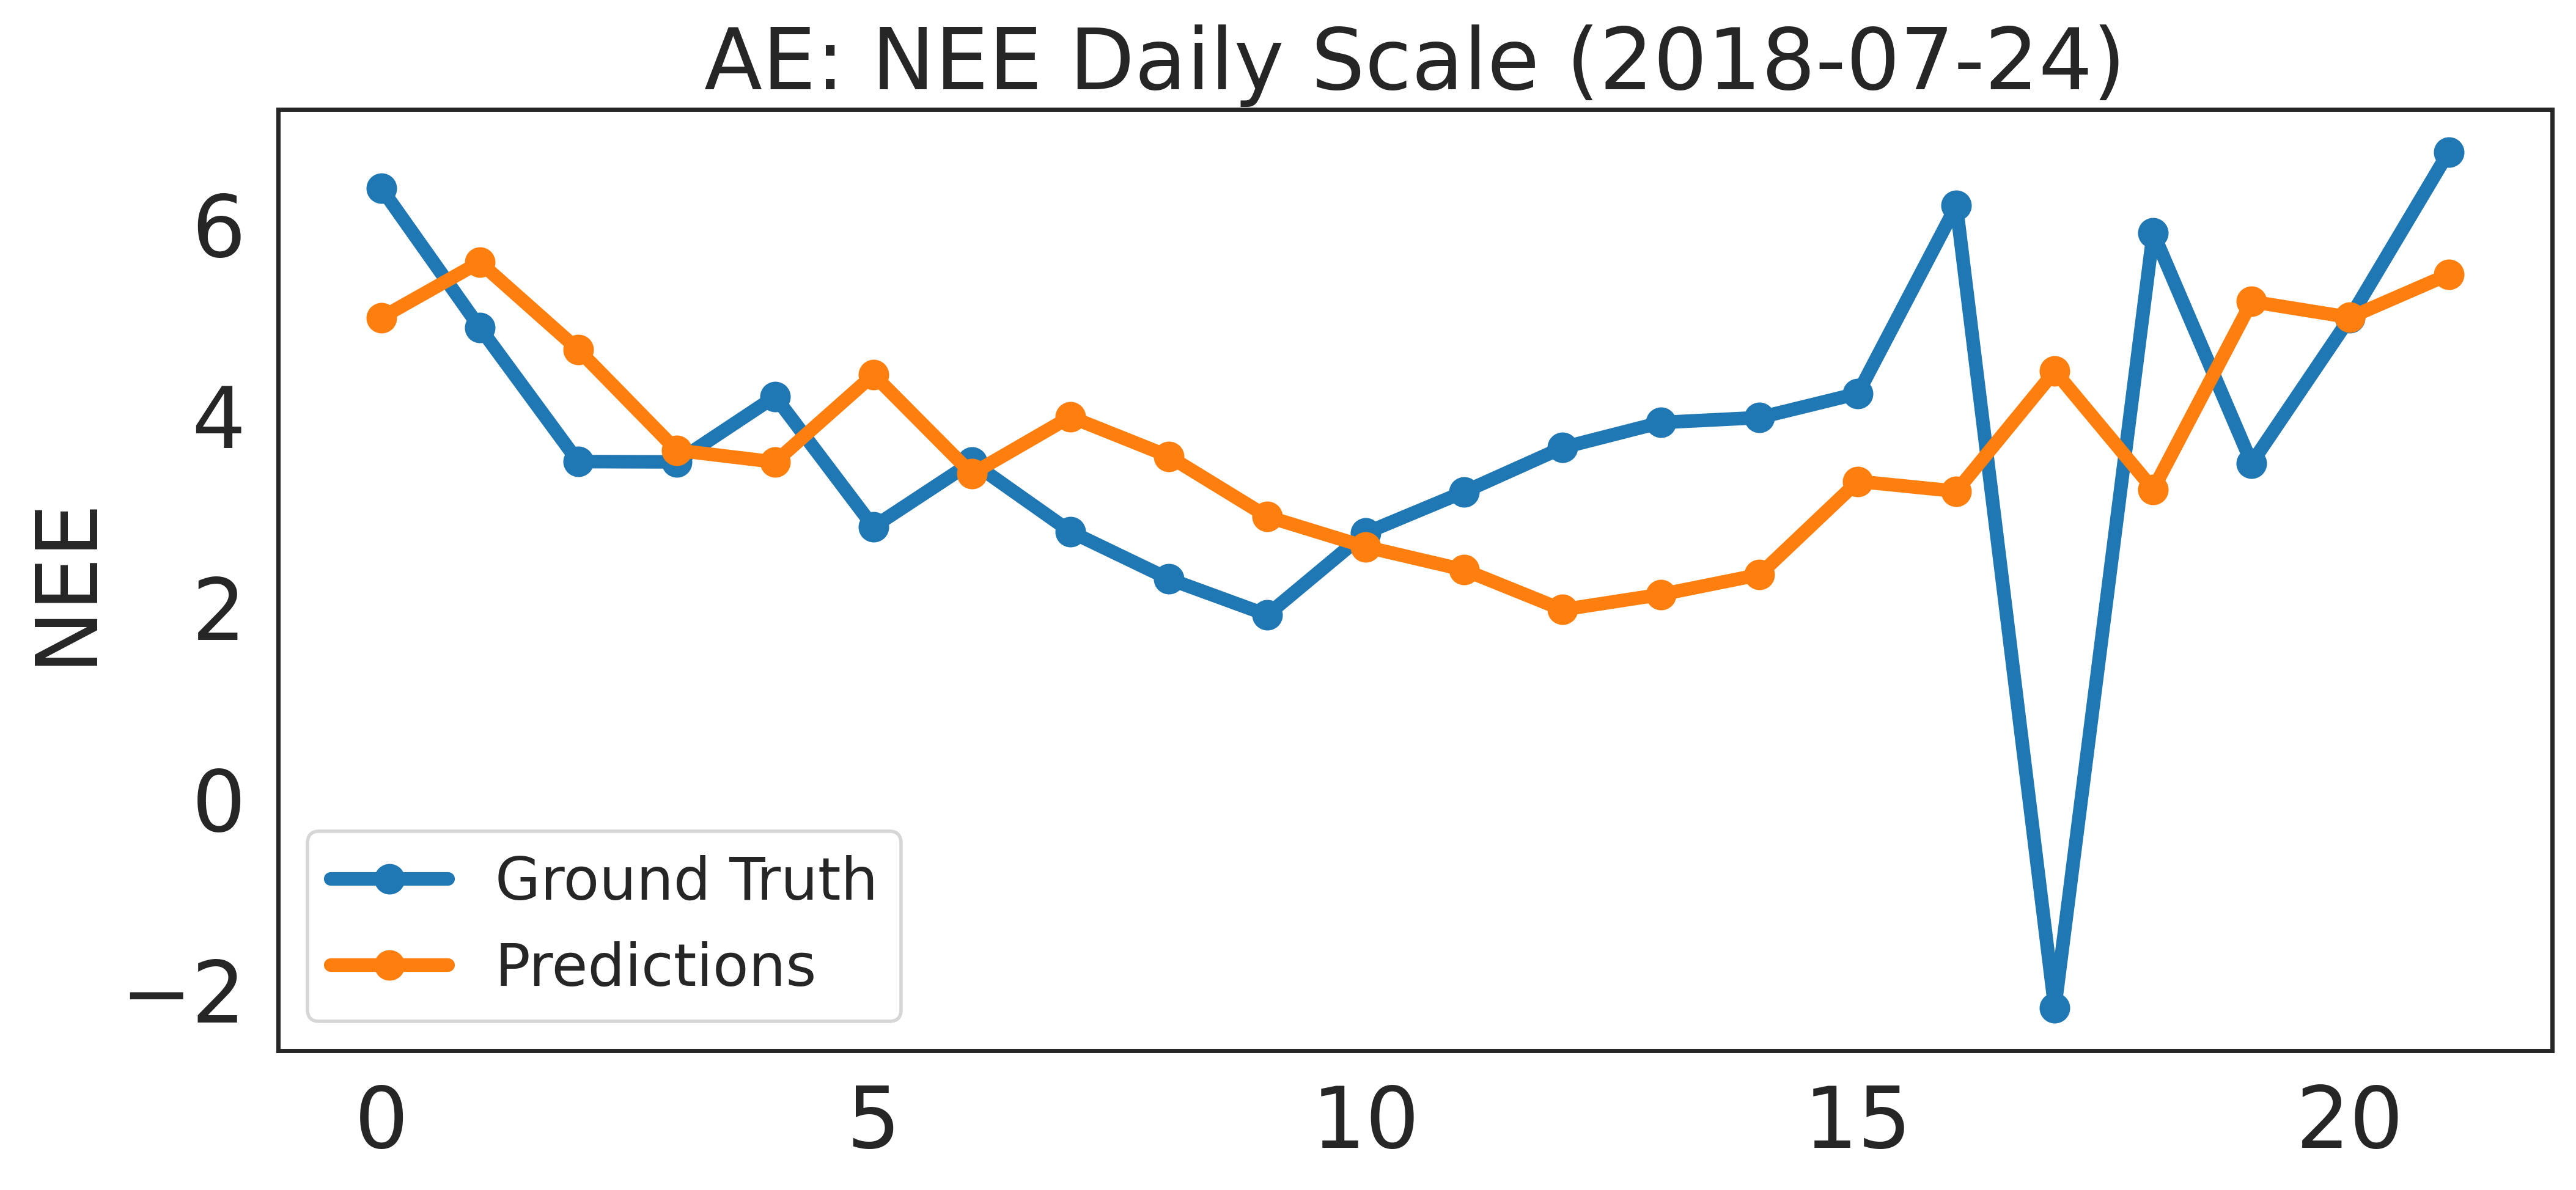

In [33]:
### Daily

test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 6).values

date = test_data.DateTime[mask].iloc[0]
date = str(date).split(' ')[0]


gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)
ax.legend(["Ground Truth", "Predictions"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"AE: NEE Daily Scale ({date})", fontsize=25)
fig.savefig("ae_nee_day_daily.png", bbox_inches='tight')


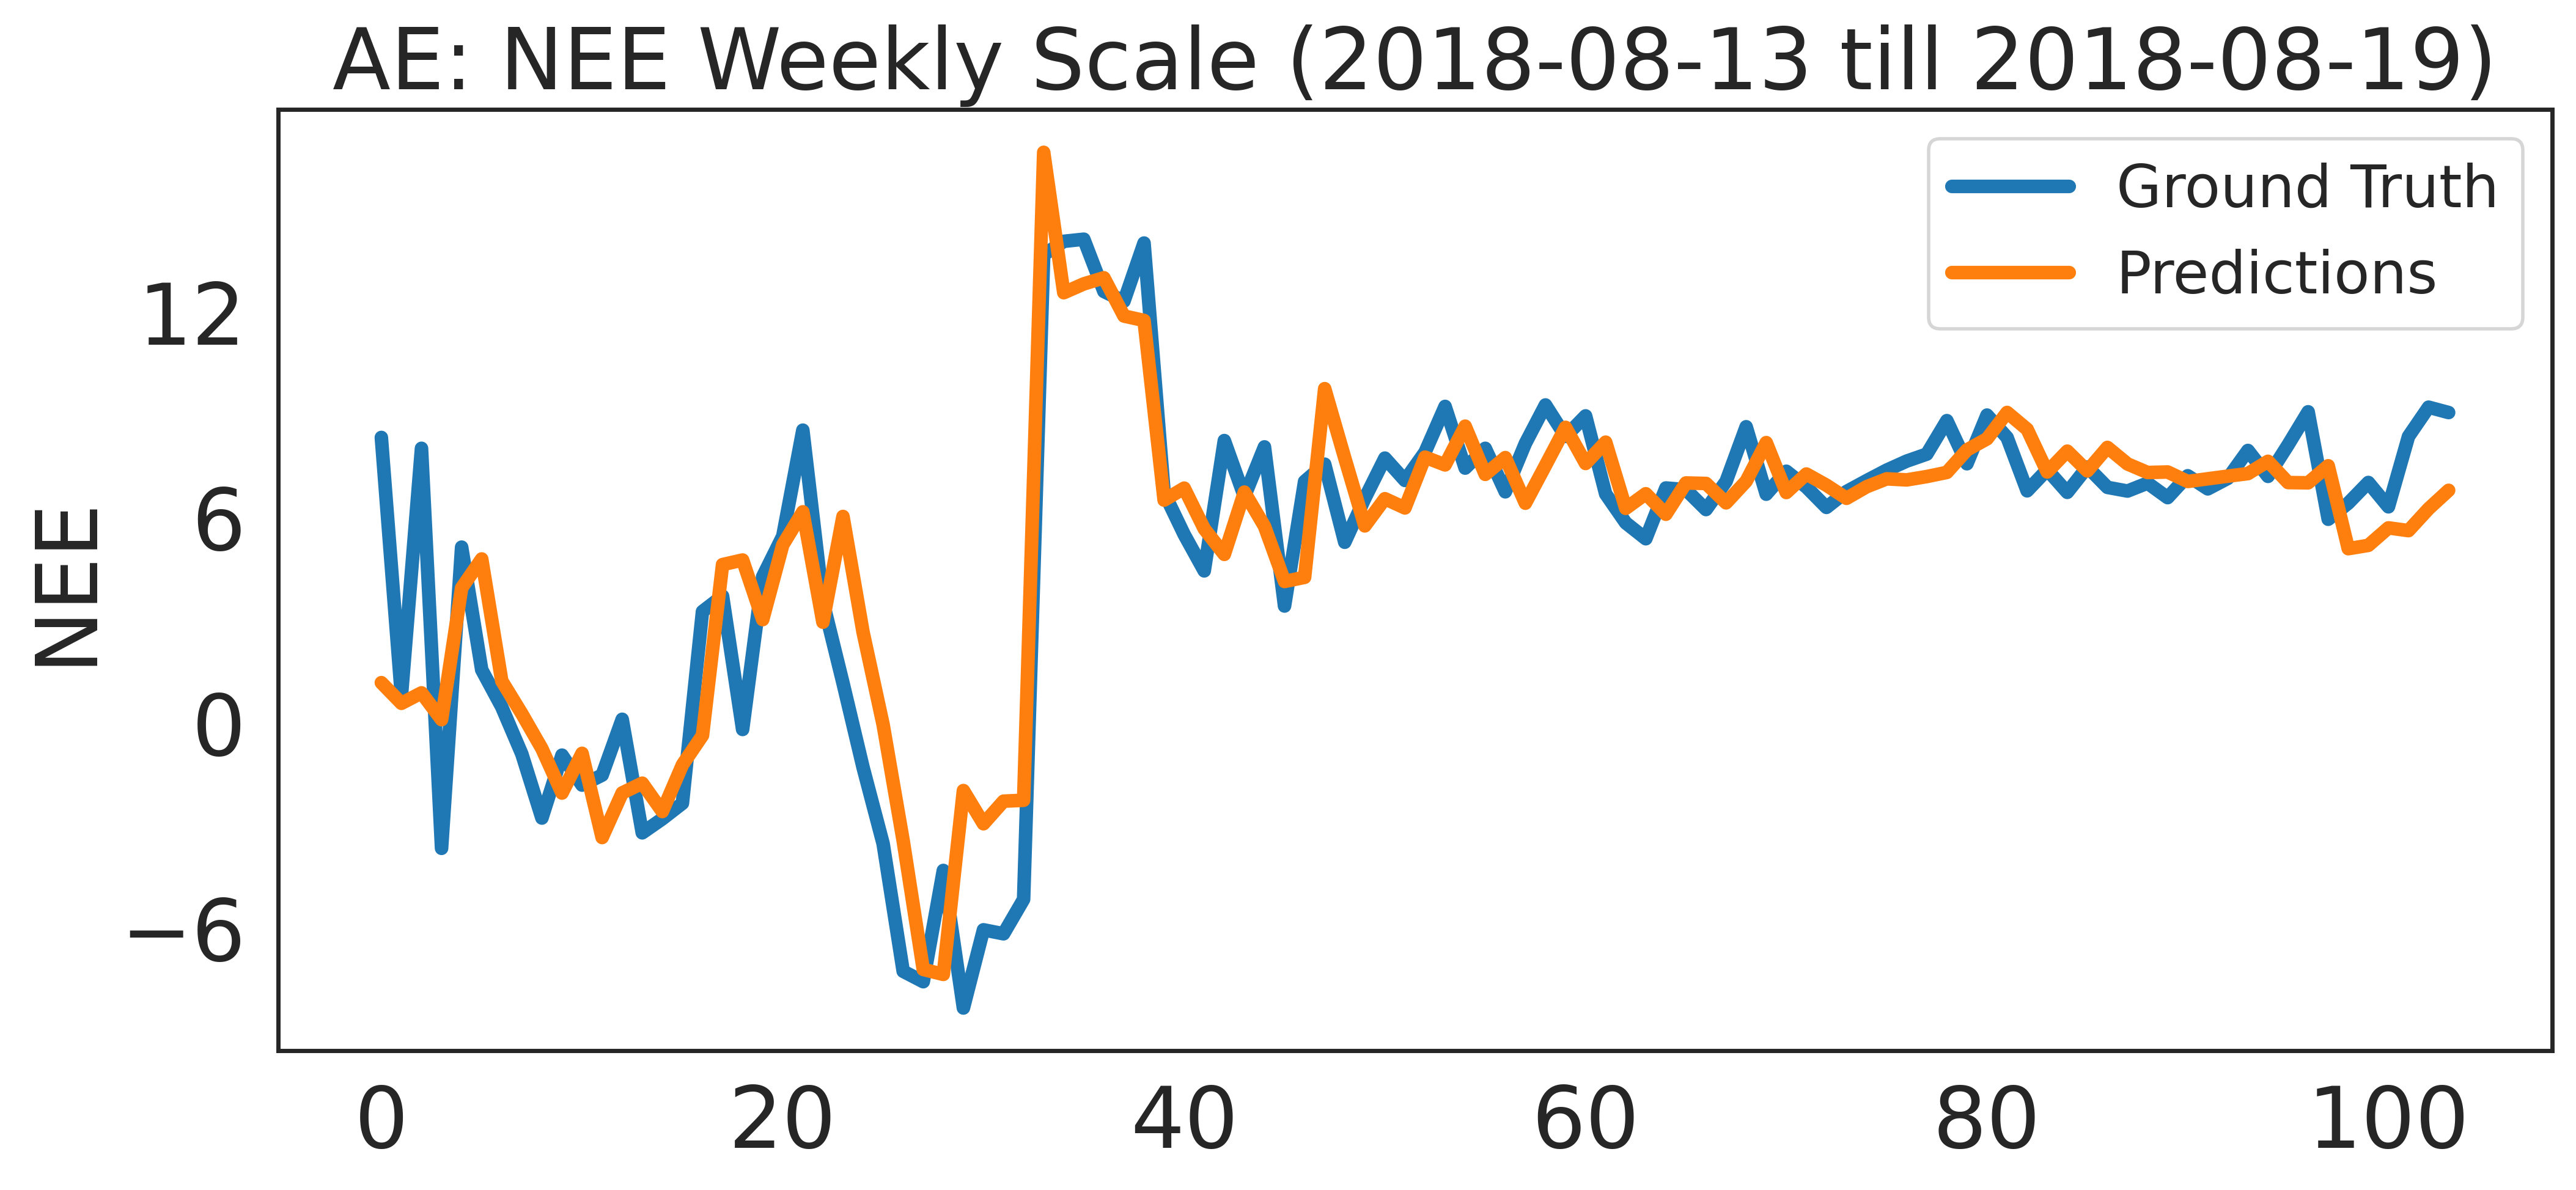

In [34]:
### Weekly

test_data['week_group'] = (test_data['dayofweek'] < test_data['dayofweek'].shift()).cumsum()

mask = test_data.week_group == 4

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, '-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, '-', color="#ff7f0e", linewidth=4, markersize=8)
ax.legend(["Ground Truth", "Predictions"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"AE: NEE Weekly Scale ({date})", fontsize=25)
fig.savefig("ae_nee_day_weekly.png", bbox_inches='tight')


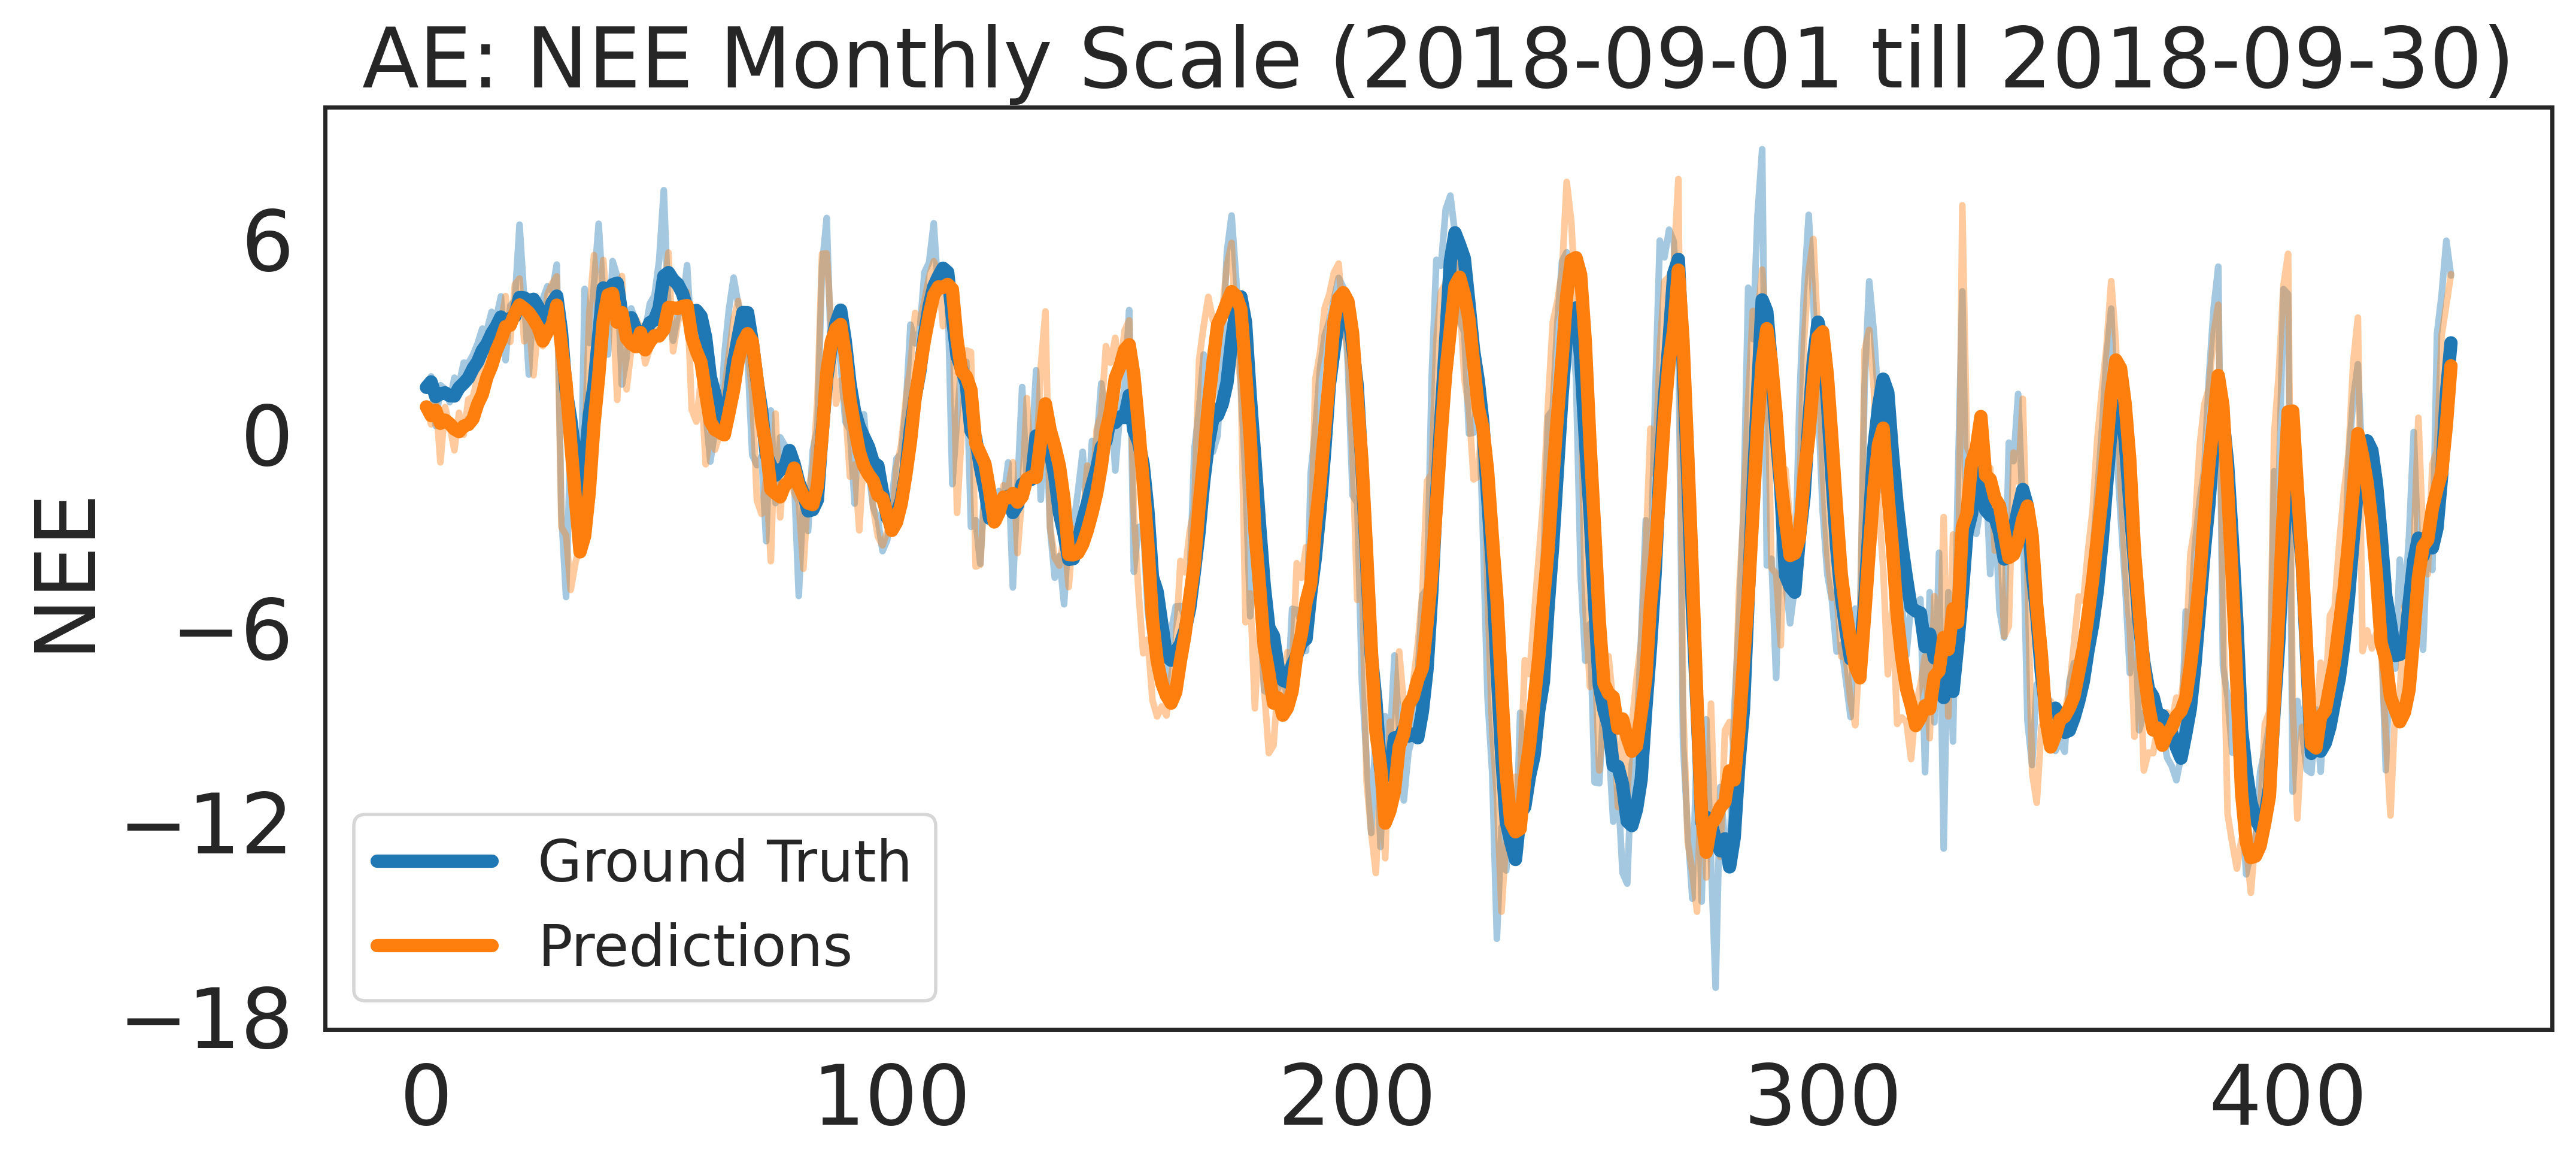

In [35]:
### Monthly

mask = (test_data.DateTime.dt.year == 2018) & (test_data.DateTime.dt.month == 9)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 5
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"AE: NEE Monthly Scale ({date})", fontsize=25)
fig.savefig("ae_nee_day_monthly.png", bbox_inches='tight')

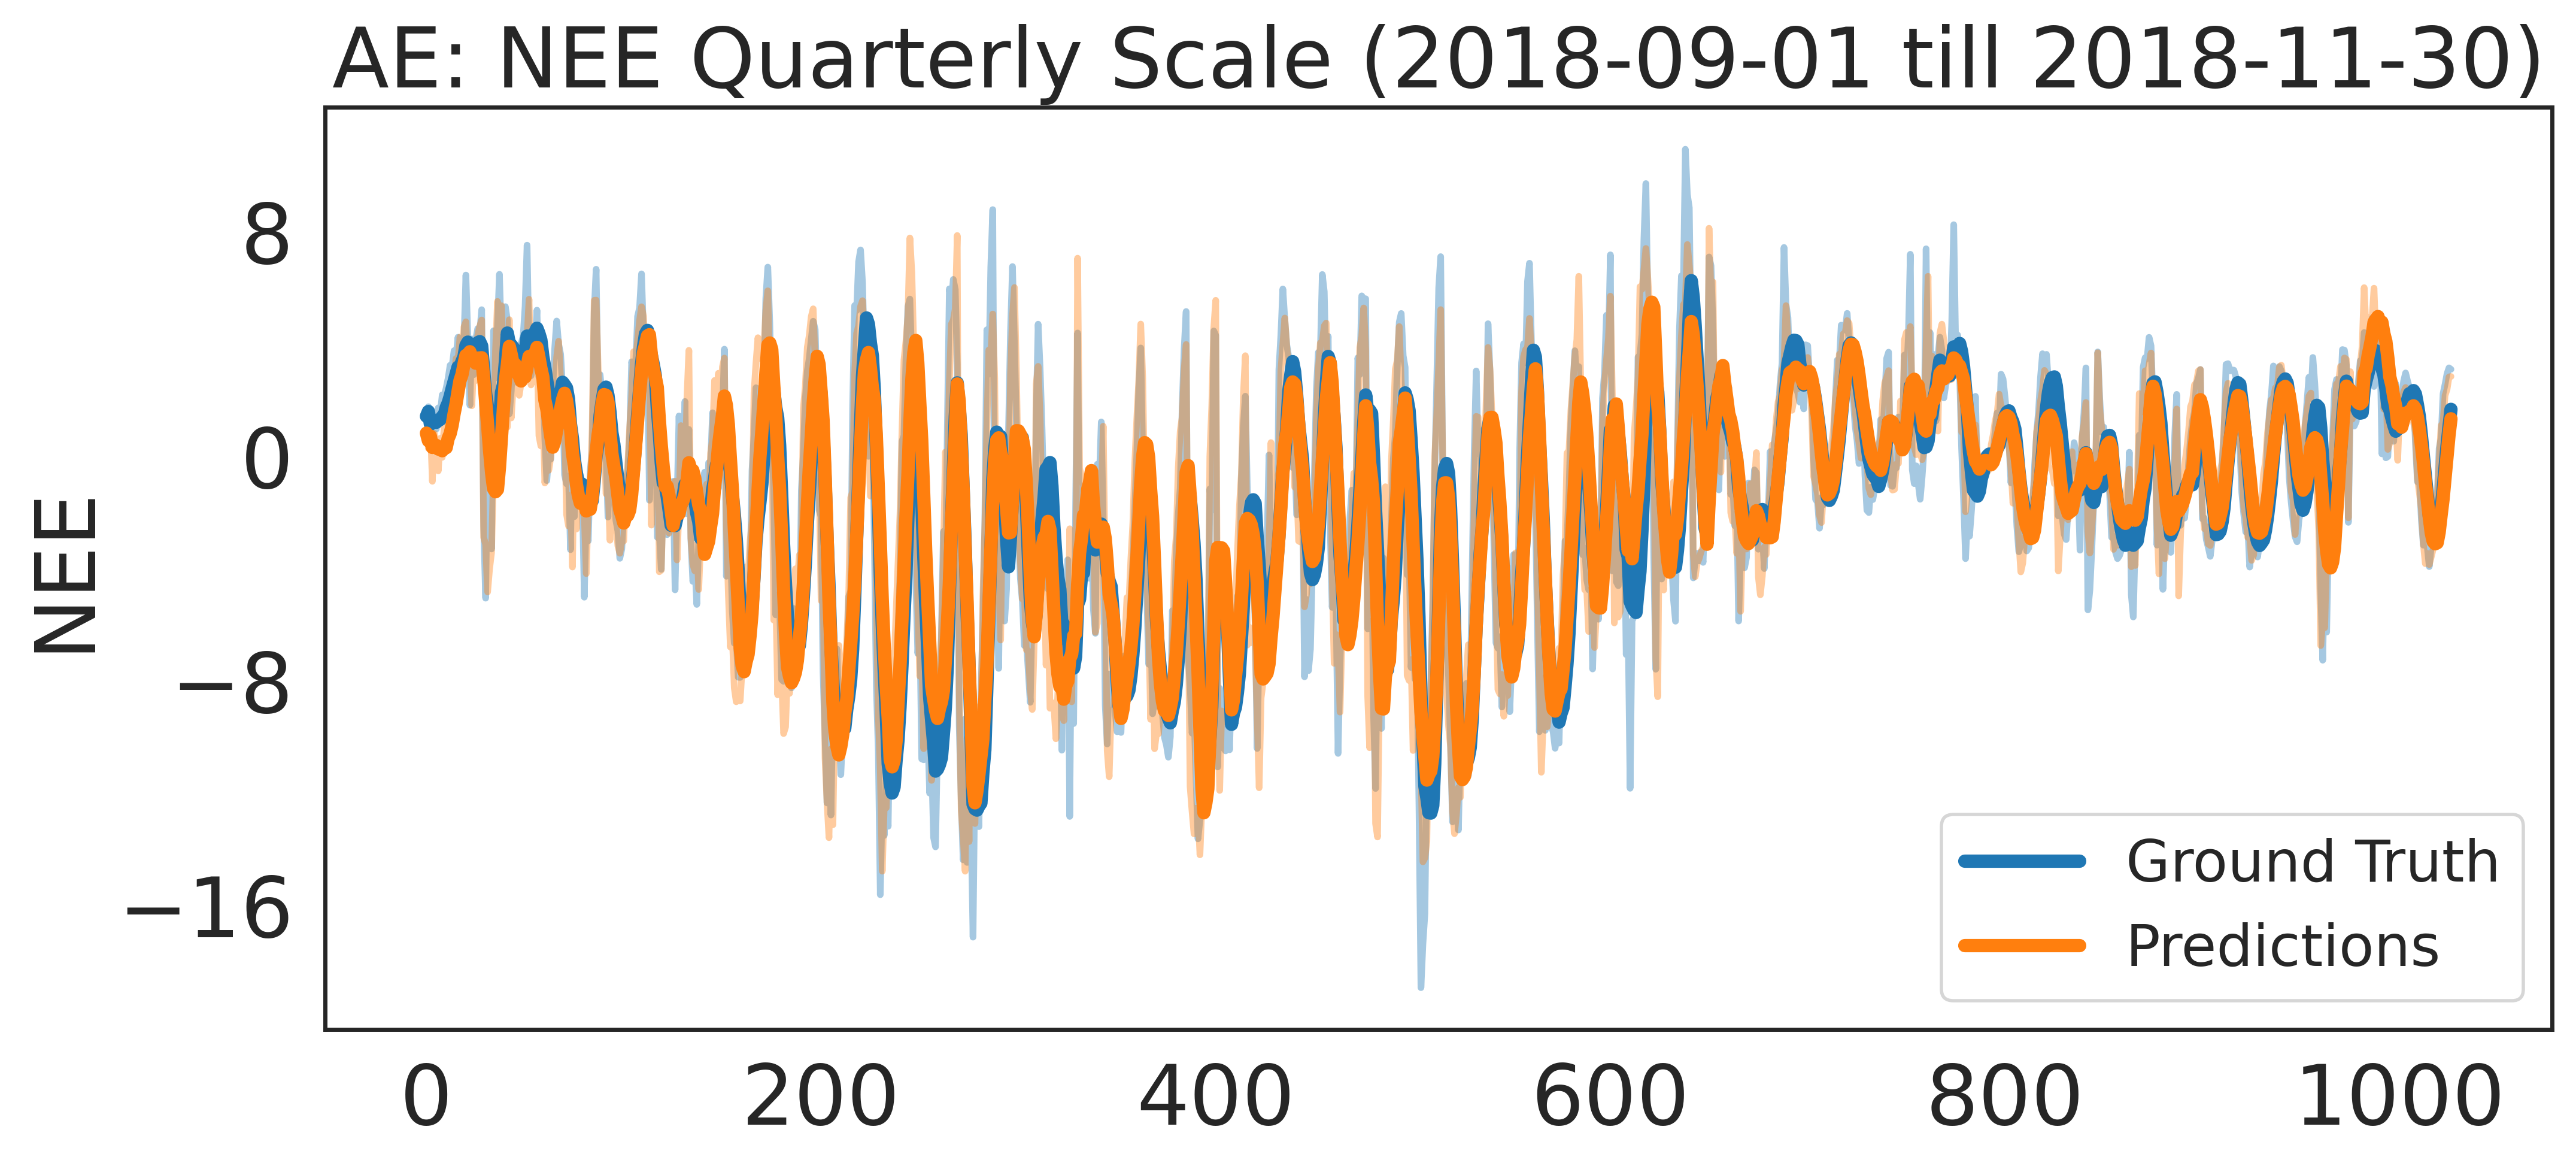

In [36]:
### Quarterly

test_data.season.unique()

mask = (test_data.DateTime.dt.year == 2018) & (test_data.season == 4)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 8
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"AE: NEE Quarterly Scale ({date})", fontsize=25)
fig.savefig("ae_nee_day_quarterly.png", bbox_inches='tight')

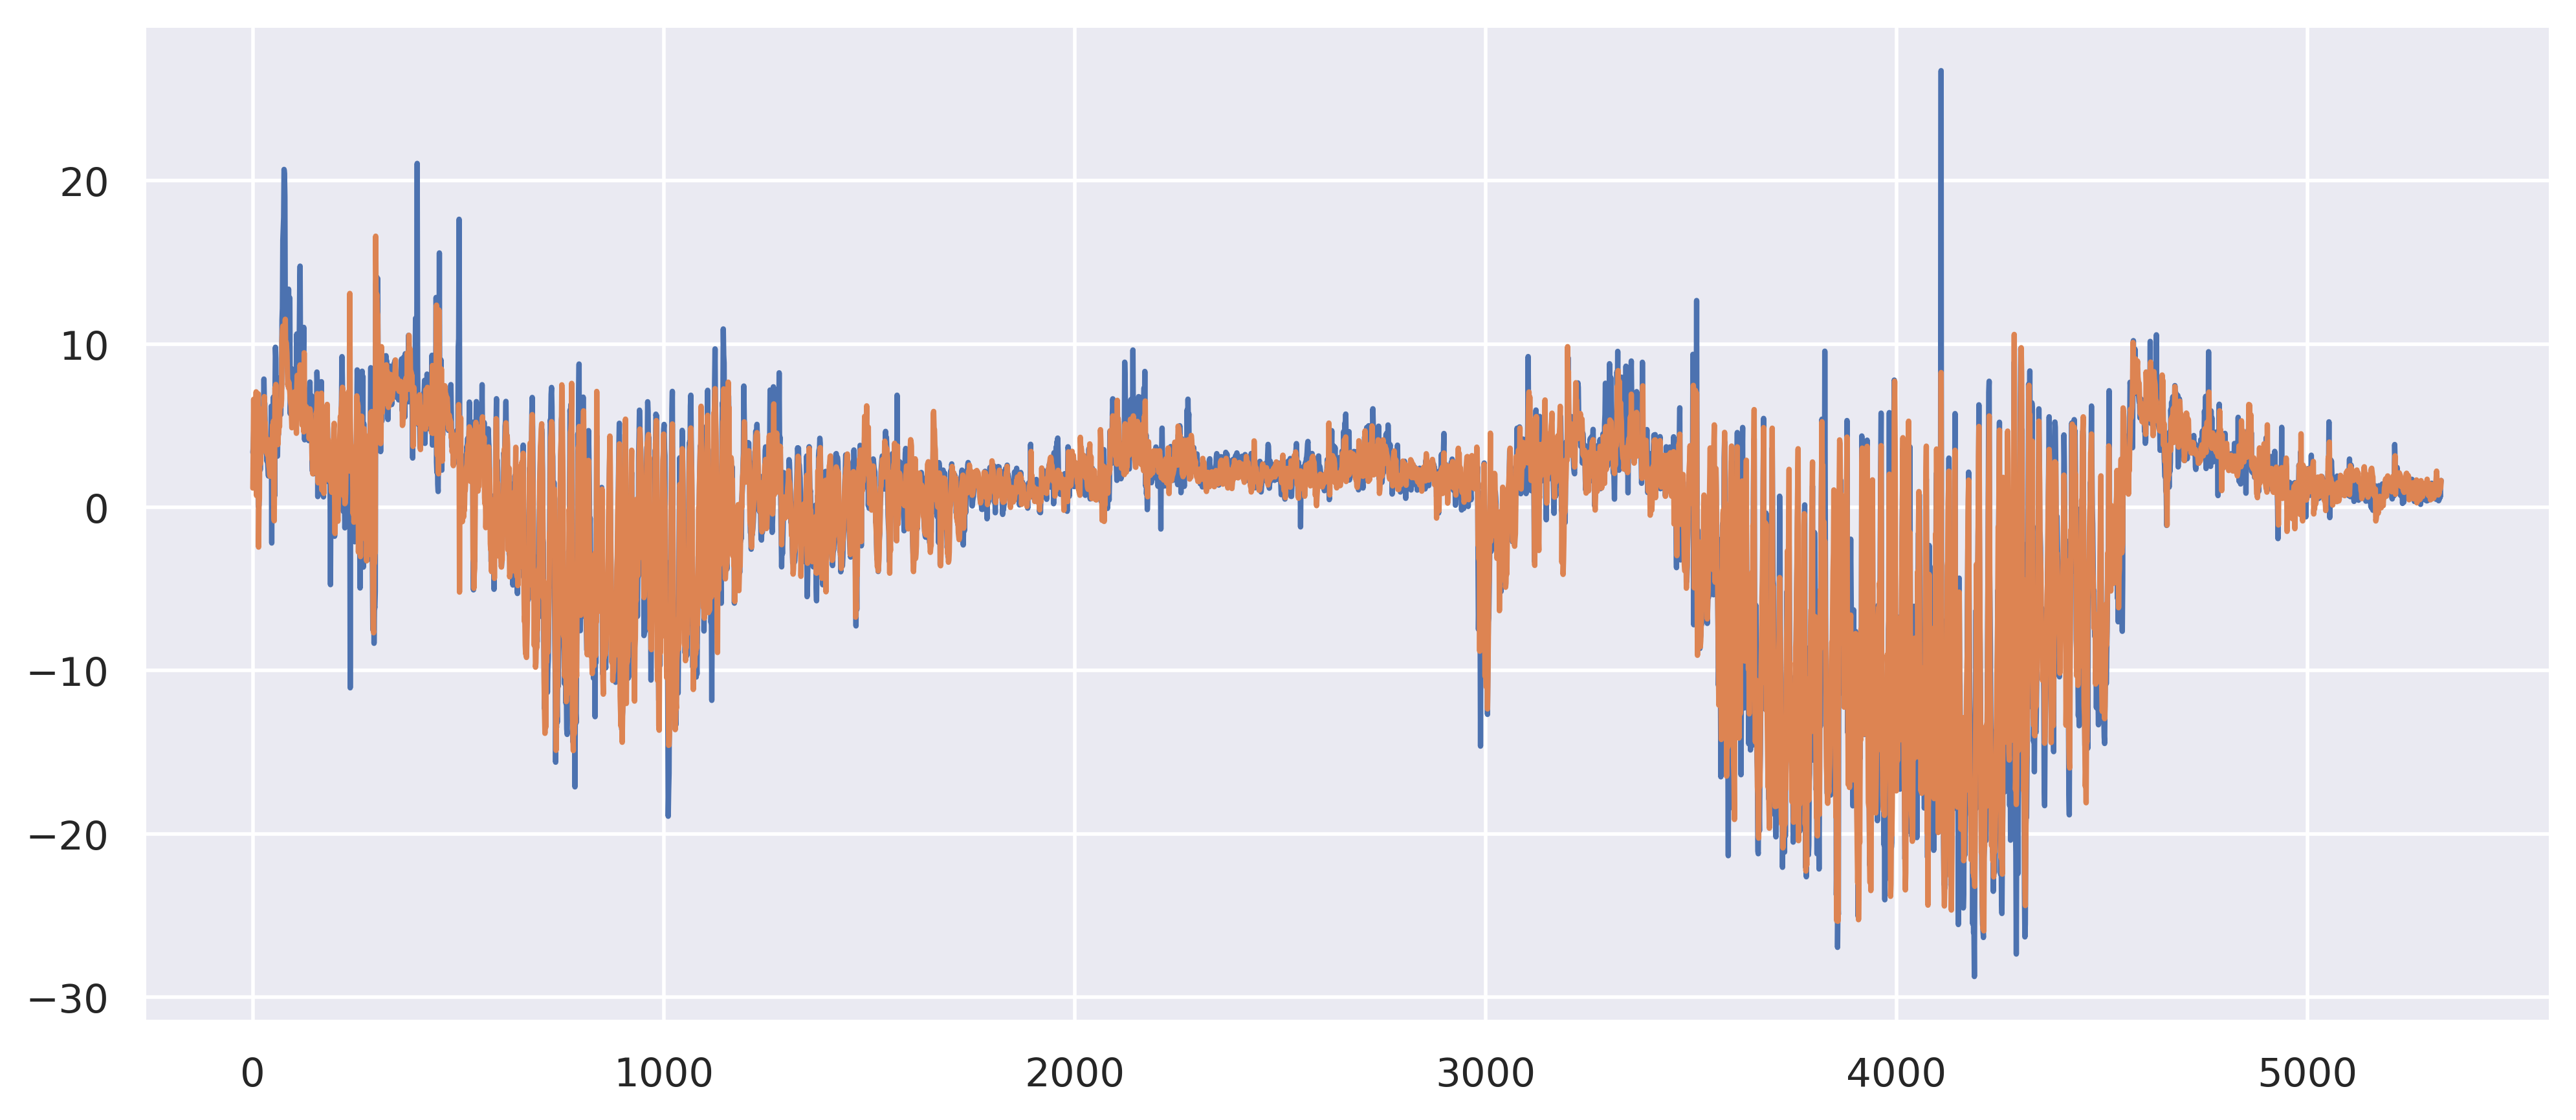

In [67]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt.nee)
ax.plot(preds.nee)
fig.savefig(save_dir.joinpath("nee_predictions.png"))

In [68]:
mask = (test_data["DateTime"].dt.month == 1).values

In [69]:
gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

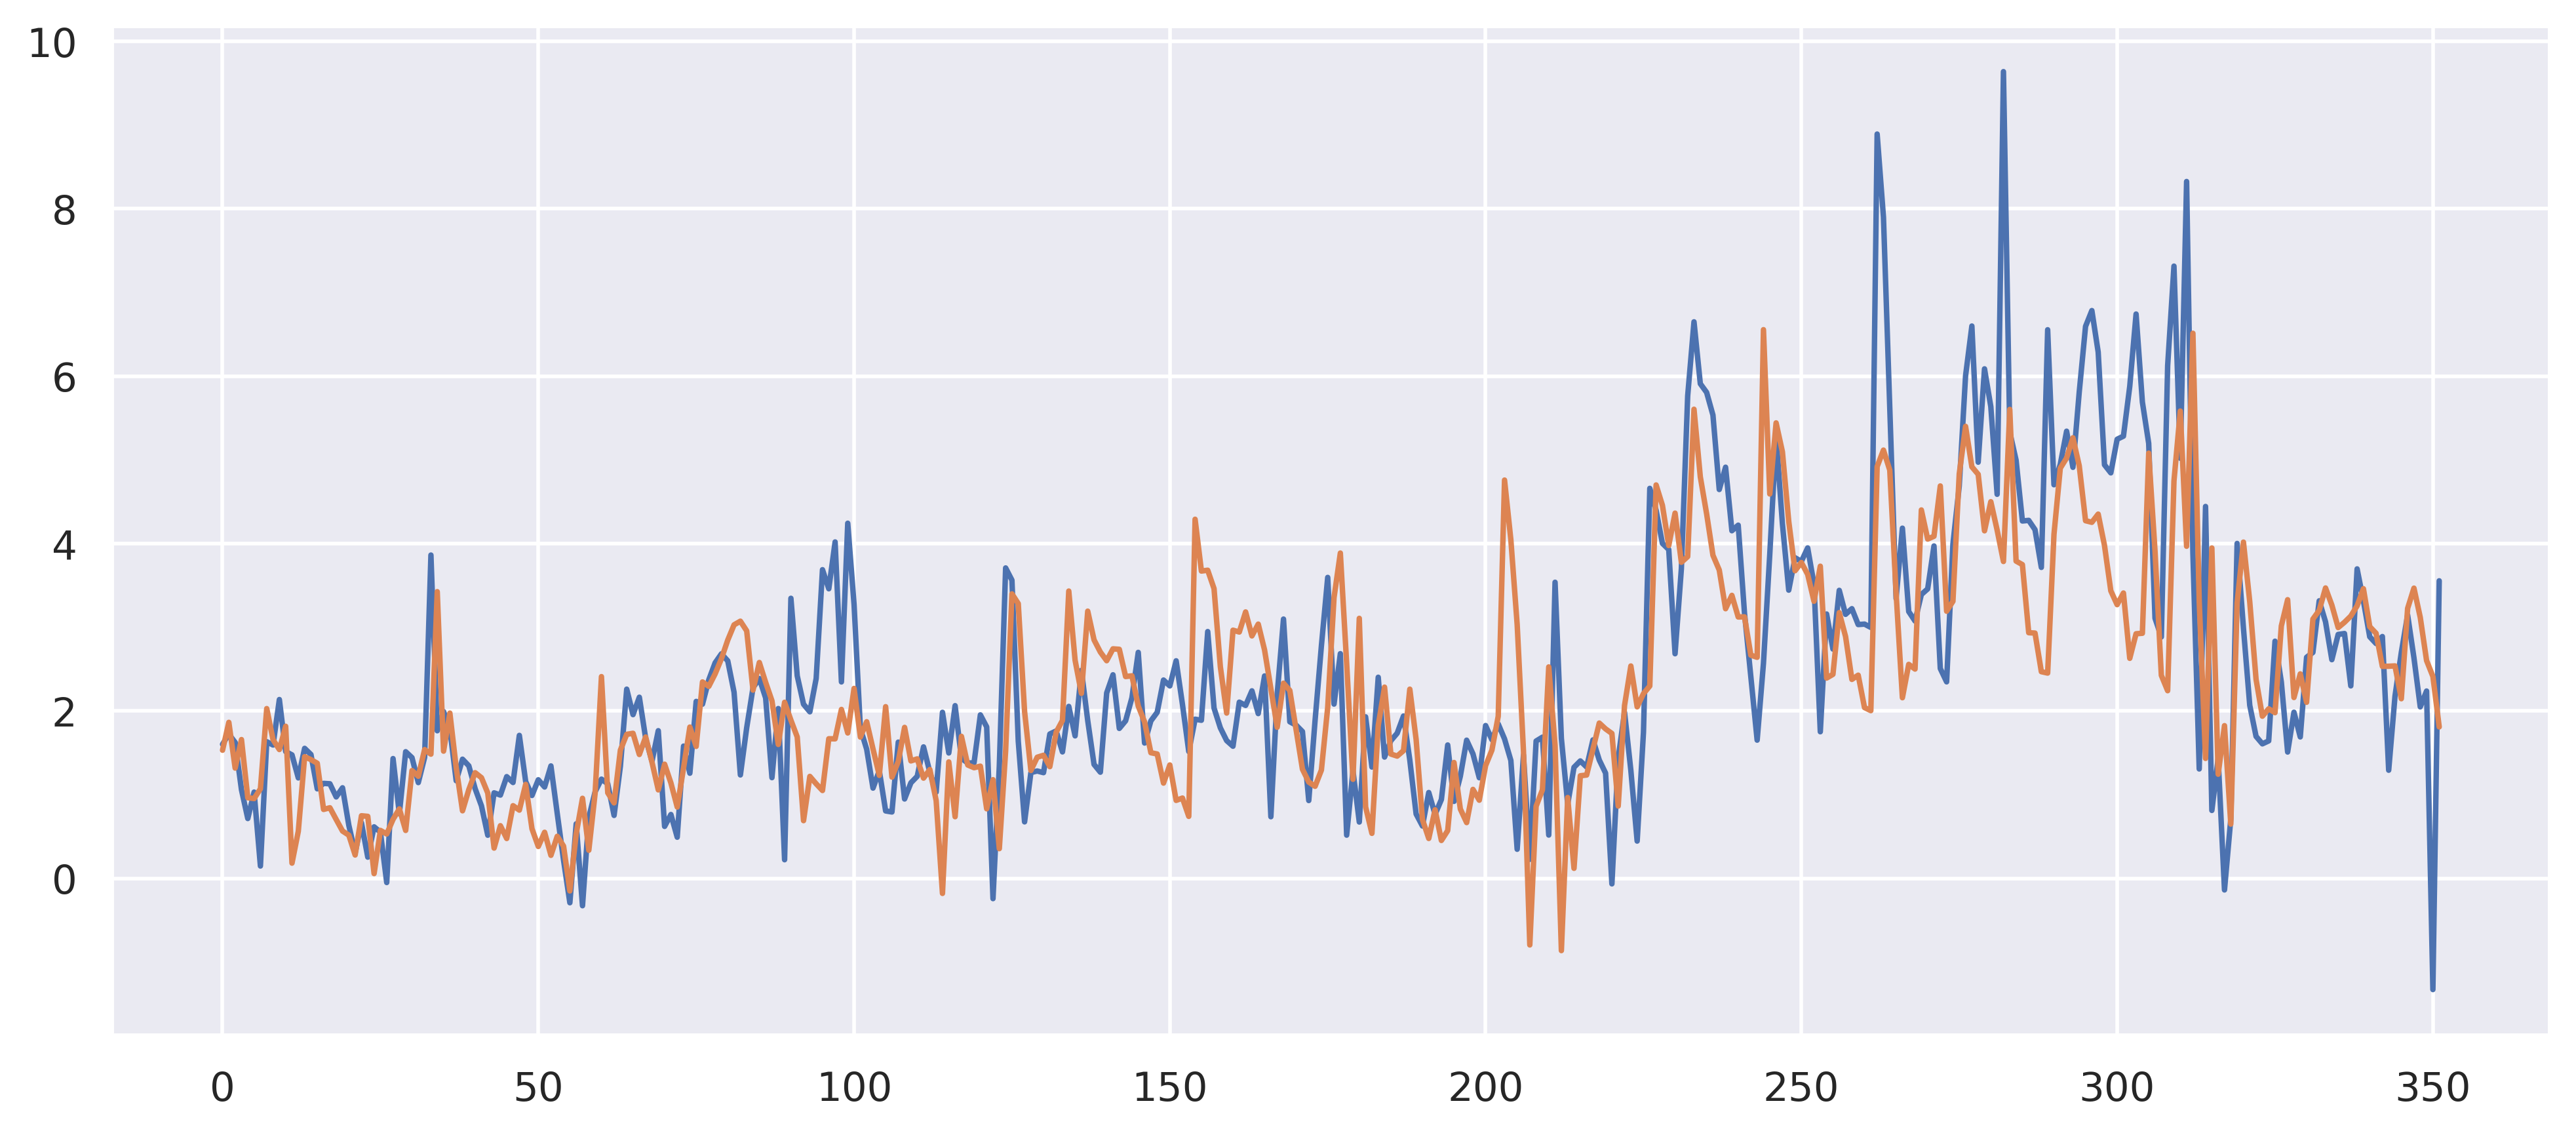

In [70]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis)
ax.plot(preds_vis)
fig.savefig(save_dir.joinpath("nee_predictions_month1.png"))

(0.0, 8.0)

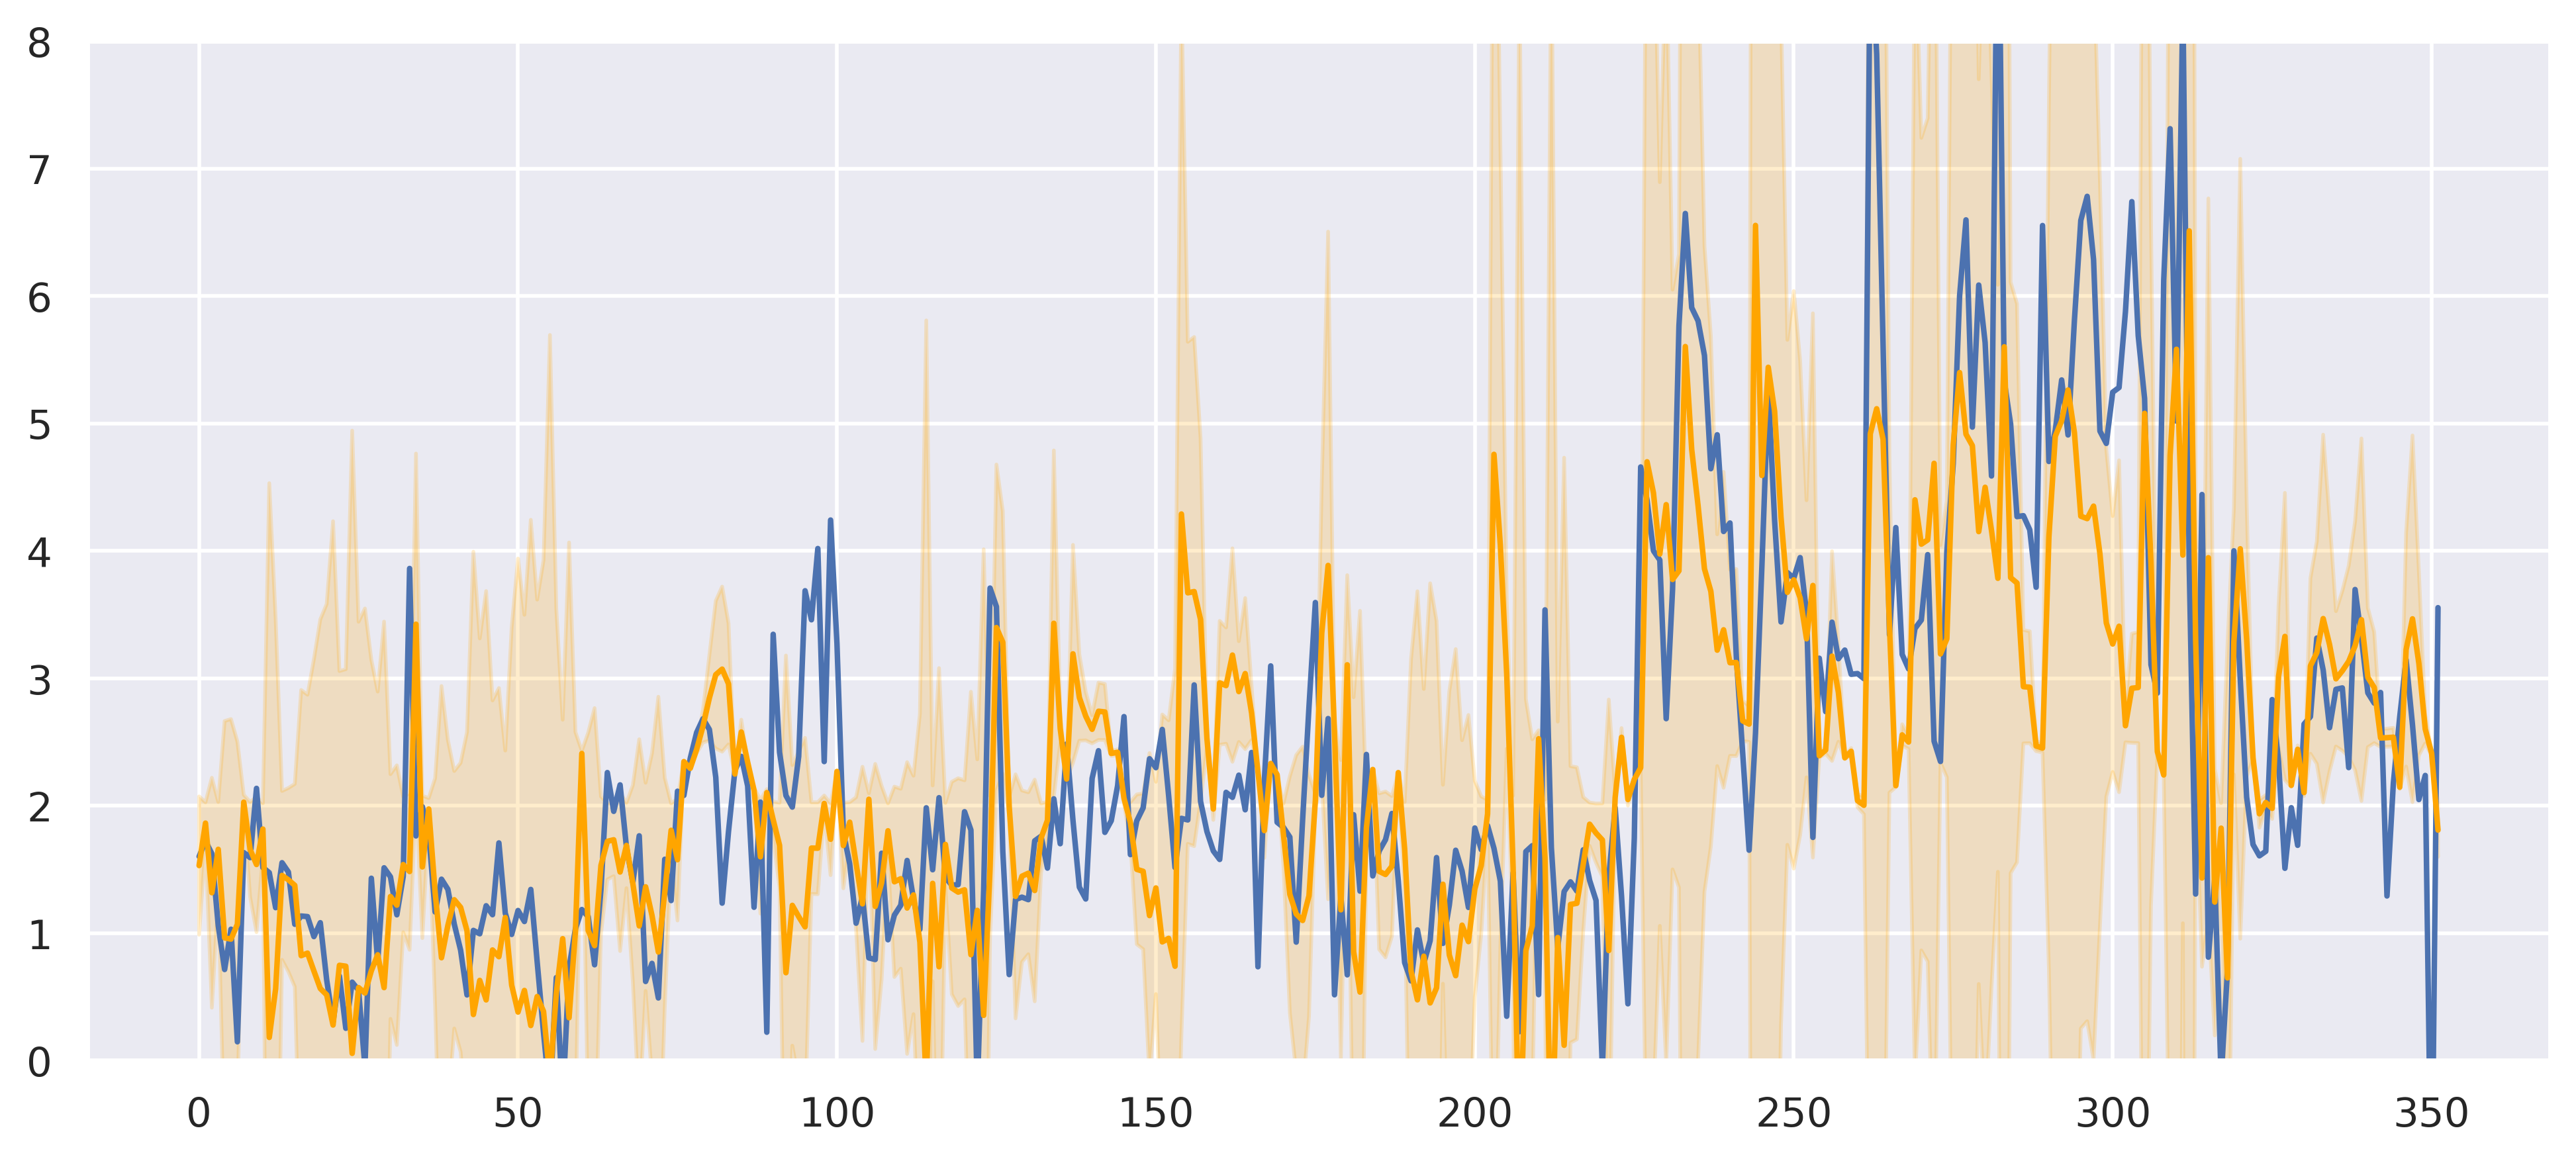

In [71]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
mu = np.mean(preds_vis)
error = np.square(preds_vis - mu)
ax.plot(gt_vis)
ax.plot(preds_vis, color="orange")
ax.fill_between(np.arange(preds_vis.shape[0]), preds_vis - error, preds_vis + error, alpha=0.2, color="orange")

ax.set_ylim(0, 8)